<a href="https://colab.research.google.com/github/willychangx/covid-ml/blob/main/eg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download folders. You don't need to change anything, you'll be downloading from my Google Drive.

# Others.zip
!gdown https://drive.google.com/uc?id=1L9dHYx2EwywfH3bWAcWPSDRCy-VsA8mX
!unzip /content/Others.zip -d /content

# Healthy.zip
!gdown https://drive.google.com/uc?id=1FQMhrVAvzBp38bMDpXnRbJZ6ghnNEKBb
!unzip /content/Healthy.zip -d /content

# Covid.zip
!gdown https://drive.google.com/uc?id=1CHCjoLEcf4imlgxp2EEphZKmiyTV6-vQ
!unzip /content/Covid.zip -d /content
%cd /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/Healthy/Patient (13)/._Captura de Tela 2020-06-02 às 10.38.15.png  
  inflating: /content/Healthy/Patient (13)/Captura de Tela 2020-06-02 às 10.37.46.png  
  inflating: /content/__MACOSX/Healthy/Patient (13)/._Captura de Tela 2020-06-02 às 10.37.46.png  
  inflating: /content/Healthy/Patient (13)/Captura de Tela 2020-06-02 às 10.37.52.png  
  inflating: /content/__MACOSX/Healthy/Patient (13)/._Captura de Tela 2020-06-02 às 10.37.52.png  
  inflating: /content/Healthy/Patient (13)/Captura de Tela 2020-06-02 às 10.38.07.png  
  inflating: /content/__MACOSX/Healthy/Patient (13)/._Captura de Tela 2020-06-02 às 10.38.07.png  
  inflating: /content/Healthy/Patient (13)/Captura de Tela 2020-06-02 às 10.37.41.png  
  inflating: /content/__MACOSX/Healthy/Patient (13)/._Captura de Tela 2020-06-02 às 10.37.41.png  
  inflating: /content/Healthy/Patient (13)/Captura de Tela 2020-06-02 às 10.37.59.png  
  in

In [2]:
# Import libraries for the training
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, Subset, DataLoader, random_split

import os

In [4]:
# Parameters for the training
params = {
    "mean": [0.5, 0.5, 0.5], # mean subtracted from the pixel values to give optimal
    "std": [0.5, 0.5, 0.5], # same as mean, but with standard deviation
    "batch": 30, # batch size (samples per epoch)
    "child": 3, # [0, 50), number of layers of resnet to freeze
    "childchild": 1, # number of child_child to freeze
    "num_out": 16, # output of architecture
    "fc1True": True, # use bias for linear fully convolutional
    "fc2True": True, # use bias for linear fully convolutional
    "lr": 1e-2, # learning rate for adam optimizer
    "wd": 0, # weight decay for adam optimizer
    "epochs": 2, # number of epochs (iterations)
    "percent": 0.20, # % of the dataset to split up (1/percent = # of folds for cross validation)
}

In [5]:
# Import more libraries as they become relevant
import cv2
import shutil
import math
import random

# Declare the types of classification
types = ['Covid', 'Others', 'Healthy']
newFolderPath = []

# Input: Single folder name
# Output: Combine all images in subfolders into one folder called ./new_{patientType}
def combine_images(patientType) -> int:
    origDir = os.getcwd()
    currDir = origDir + '/' + patientType
    newFolder = origDir + '/new_' + patientType
    newFolderPath.append(newFolder)

    # If the folder to be created exists, delete and create a new one
    if os.path.isdir(newFolder):
        shutil.rmtree(newFolder)
    os.mkdir(newFolder)
    index = 0

    # Start going through each folder to extract image and paste into a new folder
    for folder in os.listdir(currDir):
        if os.path.isdir(currDir + '/' + folder):
            for filename in os.listdir(currDir + '/' + folder):
                if filename.endswith(".png"):
                    img = cv2.imread(currDir + '/' + folder + '/' + filename)
                    img = cv2.resize(img, (200, 200), interpolation=cv2.INTER_CUBIC)
                    cv2.imwrite(newFolder + '/' + str(index) + '.png', img)
                    index += 1
                    # Rotate images by 90, 180, 270 to increase the dataset
                    for x in range(3):
                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        cv2.imwrite(newFolder + '/' + str(index) + '.png', img)
                        index += 1
    # In case you already have the folders and don't want to go through everything
    # if patientType == 'Covid':
    #     index = 8668
    # elif patientType == 'Others':
    #     index = 4988
    # else:
    #     index = 3028
    
    print(f"Folder {patientType}: {index} files")

# For each classification folder, combine all images into a new folder    
for name in types:
    combine_images(name)

Folder Covid: 8668 files
Folder Others: 4988 files
Folder Healthy: 3028 files


In [6]:
# Input: An array of paths to the new folders
# Output: 5 new folders with 20% of the dataset each
def cross_validation_segments(paths) -> list:
    # Check if folders exist; Delete and make new if they do
    currDir = os.getcwd()
    randList = []
    for i in range(5):
        if os.path.isdir('Rand' + str(i)):
            shutil.rmtree('Rand' + str(i))
        os.mkdir('Rand' + str(i))
        randList.append(currDir + '/Rand' + str(i))

    arrIdx = [0 for i in range(5)]
    idx = 0
    arr = []
    id = 0

    # Create an array of all images and paths
    for path in paths:
        arr = [path + '/' + folder for folder in os.listdir(path)]
        # While there are still elements in the array
        while len(arr):
            # Randomly choose an image and place them into a folder
            val = random.randrange(len(arr))
            shutil.copyfile(arr[val], './Rand' + str(idx) + '/' + str(id) + '_' + str(arrIdx[idx]) + '.png')
            del arr[val]
            arrIdx[idx] += 1
            idx += 1
            idx %= 5
        id += 1
    return randList

randFolders = cross_validation_segments(newFolderPath)

In [15]:
# Input: Path
# Output: Array of images in path
def read_images(path) -> list:
    images = [cv2.imread(path + '/' + img) for img in os.listdir(path)]
    return images

# Input: Path
# Output: Array of numbers (labels)
def read_labels(path):
    labels = [open(path + '/' + lbl, "r").read() for lbl in os.listdir(path)]
    return labels

# DataSet class to override some Dataset methods (functions)
class DataSet(Dataset):
    def __init__(self, root, iteration, randFolders):
        idx = 0
        currDir = os.getcwd()
        train = False

        # Create the ./Dataset/(Train/Test)/(image/label) folders
        folderNames = root.split('/')
        for name in folderNames:
            if name != '.' and name != '':
                try:
                    os.mkdir(name)
                    os.chdir(name)
                except:
                    os.chdir(name)
            if name == 'Train':
                train = True
        os.mkdir('image')
        os.mkdir('label')

        # If it's not the training folder, use only one Rand folder
        if not train:
            for file in os.listdir(randFolders[iteration]):
                id = file.split('_')[0]
                shutil.copy2(randFolders[iteration] + '/' + str(file), './image/' + str(idx) + '.png')
                fp = open("./label/" + str(idx) + '.txt', "w")
                fp.write(str(id))
                idx += 1
        # Otherwise, use the other folders
        else:
            for num, folder in enumerate(randFolders):
                if num != iteration:
                    for file in os.listdir(folder):
                        id = file.split('_')[0]
                        shutil.copy2(folder + '/' + str(file), './image/' + str(idx) + '.png')
                        fp = open("./label/" + str(idx) + '.txt', "w")
                        fp.write(str(id))
                        idx += 1
      
        os.chdir(currDir)
        
        self.ROOT = root
        self.images = read_images(root + "/image")
        self.labels = read_labels(root + "/label")

    def __len__(self):
        # Return number of points in the dataset

        return len(self.images)

    def __getitem__(self, idx):
        # Here we have to return the item requested by `idx`. The PyTorch DataLoader class will use this method to make an iterable for training/validation loop.

        img = self.images[idx]
        label = self.labels[idx]

        if self.transform

        return {'image': img, 'label': label }

In [8]:
import torchvision.models as models

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: [Transfer learning with pre-trained ResNet-50] 1) Define how many first layers of convolutoinal neural network (CNN) feature extractor in ResNet-50 to be "frozen" and 2) design your own fully-connected network (FCN) classifier.
        # 1) You will only refine last several layers of CNN feature extractor in ResNet-50 that mainly relate to high-level vision task. Determine how many first layers of ResNet-50 should be frozen to achieve best performances. Commented codes below will help you understand the architecture, i.e., "children", of ResNet-50.
        # 2) Design your own FCN classifier. Here I provide a sample of two-layer FCN.
        # Refer to PyTorch documentations of torch.nn to pick your layers. (https://pytorch.org/docs/stable/nn.html)
        # Some common Choices are: Linear, ReLU, Dropout, MaxPool2d, AvgPool2d
        # If you have many layers, consider using nn.Sequential() to simplify your code
        
        # Load pretrained ResNet-50
        self.model_resnet = models.resnet50(pretrained=True)
        
        # The code below can show children of ResNet-50
        # child_counter = 0
        # for child in self.model_resnet.children():
        #    print(" child", child_counter, "is -")
        #    print(child)
        #    child_counter += 1
        
        # TODO: Determine how many first layers of ResNet-50 to freeze
        child_counter = 0
        for child in self.model_resnet.children():
            if child_counter < params['child']:
                for param in child.parameters():
                    param.requires_grad = False
            elif child_counter == params['child']:
                children_of_child_counter = 0
                for children_of_child in child.children():
                    if children_of_child_counter < params['childchild']:
                        for param in children_of_child.parameters():
                            param.requires_grad = False
                    else:
                        children_of_child_counter += 1
            else:
                print("child ",child_counter," was not frozen")
            child_counter += 1
        
        # Set ResNet-50's FCN as an identity mapping
        num_fc_in = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        
        # TODO: Design your own FCN
        self.fc1 = nn.Linear(num_fc_in, params['num_out'], bias = params['fc1True']) # from input of size num_fc_in to output of size ?
        self.fc2 = nn.Linear(params['num_out'], 3, bias = params['fc2True']) # from hidden layer to 3 class scores

    def forward(self,x):
        # TODO: Design your own network, implement forward pass here
        
        relu = nn.ReLU() # No need to define self.relu because it contains no parameters
        
        with torch.no_grad():
            features = self.model_resnet(x)
            
        x = self.fc1(features) # Activation are flattened before being passed to the fully connected layers
        x = relu(x)
        x = self.fc2(x)
        
        # The loss layer will be applied outside Network class
        return x

Loading datasets...
Done!


  0%|          | 1/445 [00:00<00:57,  7.66it/s]

child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
2048
Start training...


  0%|          | 1/445 [00:00<00:55,  8.05it/s]

Epoch 1 loss:0.003135812092954837


100%|██████████| 445/445 [00:55<00:00,  8.01it/s]


Epoch 2 loss:0.0
Done!


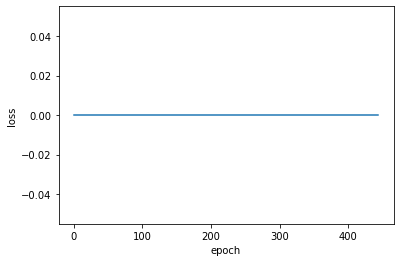

  0%|          | 0/112 [00:00<?, ?it/s]

Evaluate on test set


100%|██████████| 112/112 [00:13<00:00,  8.47it/s]


Evaluation accuracy: 1.0
Loading datasets...
Done!


  0%|          | 0/445 [00:00<?, ?it/s]

child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
2048
Start training...


  0%|          | 1/445 [00:00<00:55,  7.97it/s]

Epoch 1 loss:0.0025197146691107878


100%|██████████| 445/445 [00:55<00:00,  8.05it/s]


Epoch 2 loss:0.0
Done!


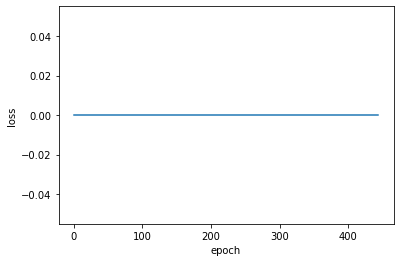

  0%|          | 0/112 [00:00<?, ?it/s]

Evaluate on test set


100%|██████████| 112/112 [00:13<00:00,  8.35it/s]


Evaluation accuracy: 1.0
Loading datasets...
Done!


  0%|          | 0/445 [00:00<?, ?it/s]

child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
2048
Start training...


  0%|          | 1/445 [00:00<00:57,  7.71it/s]

Epoch 1 loss:0.0025044076566772995


100%|██████████| 445/445 [00:54<00:00,  8.12it/s]


Epoch 2 loss:0.0
Done!


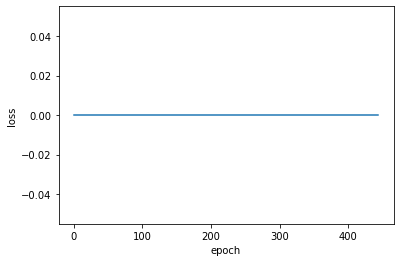

  0%|          | 0/112 [00:00<?, ?it/s]

Evaluate on test set


100%|██████████| 112/112 [00:13<00:00,  8.54it/s]


Evaluation accuracy: 1.0
Loading datasets...
Done!


  0%|          | 1/445 [00:00<01:01,  7.26it/s]

child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen
2048
Start training...


 73%|███████▎  | 327/445 [00:40<00:14,  8.17it/s]

KeyboardInterrupt: ignored

In [16]:
acc = []

for i in range((int)(1/params['percent'])):
    if os.path.isdir('Dataset'):
        shutil.rmtree('Dataset')

    # Load the dataset and train and test splits
    print("Loading datasets...")

    # Data path
    DATA_train_path = DataSet('./Dataset/Train', i, randFolders)
    DATA_test_path = DataSet('./Dataset/Test', i, randFolders)

    # Data normalization
    MyTransform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3), # Convert image to grayscale
        transforms.ToTensor(), # Transform from [0,255] uint8 to [0,1] float
        transforms.Normalize(params['mean'], params['std']) # TODO: Normalize to zero mean and unit variance with appropriate parameters
    ])

    DATA_train = datasets.ImageFolder(root=DATA_train_path.ROOT, transform=MyTransform)
    DATA_test = datasets.ImageFolder(root=DATA_test_path.ROOT, transform=MyTransform)

    print("Done!")

    # Create dataloaders
    # TODO: Experiment with different batch sizes
    trainloader = DataLoader(DATA_train, batch_size=params['batch'], shuffle=True)
    testloader = DataLoader(DATA_test, batch_size=params['batch'], shuffle=True)

    device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
    model = Network().to(device)

    criterion = nn.CrossEntropyLoss() # Specify the loss layer (note: CrossEntropyLoss already includes LogSoftMax())
    # TODO: Modify the line below, experiment with different optimizers and parameters (such as learning rate)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params['lr'], weight_decay=params['wd']) # Specify optimizer and assign trainable parameters to it, weight_decay is L2 regularization strength (default: lr=1e-2, weight_decay=1e-4)
    num_epochs = params['epochs'] # TODO: Choose an appropriate number of training epochs
    
    def train(model, loader, num_epoch = num_epochs): # Train the model
        print("Start training...")
        model.train() # Set the model to training mode
        for i in range(num_epoch):
            running_loss = []
            # test_loss = []
            for batch, label in tqdm(loader):
                batch = batch.to(device)
                label = label.to(device)
                optimizer.zero_grad() # Clear gradients from the previous iteration
                pred = model(batch) # This will call Network.forward() that you implement
                loss = criterion(pred, label) # Calculate the loss
                running_loss.append(loss.item())
                loss.backward() # Backprop gradients to all tensors in the network
                optimizer.step() # Update trainable weights
            # with torch.no_grad():
            #     for batch, label in tqdm(loader):
            #         batch = batch.to(device)
            #         label = label.to(device)
            #         optimizer.zero_grad() # Clear gradients from the previous iteration
            #         pred = model(batch) # This will call Network.forward() that you implement
            #         loss = criterion(pred, label) # Calculate the loss
            #         test_loss.append(loss.item())
            print("Epoch {} loss:{}".format(i+1,np.mean(running_loss))) # Print the average loss for this epoch
        print("Done!")
        plt.plot(running_loss)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

    def evaluate(model, loader): # Evaluate accuracy on validation / test set
        model.eval() # Set the model to evaluation mode
        correct = 0
        with torch.no_grad(): # Do not calculate grident to speed up computation
            for batch, label in tqdm(loader):
                batch = batch.to(device)
                label = label.to(device)
                pred = model(batch)
                correct += (torch.argmax(pred,dim=1)==label).sum().item()
        acc = correct/len(loader.dataset)
        print("Evaluation accuracy: {}".format(acc))
        return acc
      
    train(model, trainloader, num_epochs)
    print("Evaluate on test set")
    acc.append(evaluate(model, testloader))

print(f"Average Accuracy: {np.mean(acc)}")